**Exercise 6 - Hog Descriptor**

---

In this exercise you will implement the hog descriptor and use it for person detection/classification. Hog descriptor was widely used before for person detection, by extracting the features from the image and using a classifier to classify the image as a person or not. In this assignment you will implement the Hog Descriptor, and will be able to use your implementation to train a person classifier in a small dataset.

In [1]:
# import libraries used during this exercise
# it may be necessary to uncomment the two following pip commands
#!pip3 install opencv-python
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# the core.py file contains the plottings and other pre-defined functions
from mlrcv.core import *
%matplotlib notebook
%matplotlib inline

In this assignment we will be using a small dataset with person and non-person images. You can take a look on the images in `data/person` and `data/non_person` directory.

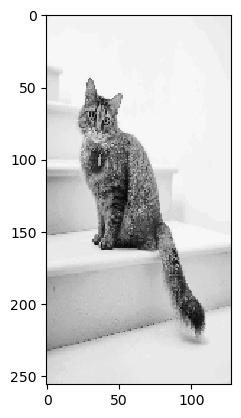

In [2]:
# Load images and divide into train and validation data
(train_data, train_labels), (val_data, val_labels) = load_data('./data')

img = load_image('./data/cat.jpg')
plt.imshow(img, cmap='gray')

**6.1 Magnitude image \[5\]**

---

Given an image $I$ your fist task will be to implement a function to compute the magnitude or the gradients from this image. This function should iterate over each pixel of the image and calculate the gradients $Gx_{ij}$ and $Gy_{ij}$ for each pixel $P_{ij}$, where $Gx_{ij} = P_{i{j+1}} - P_{i{j-1}}$ and $Gy_{ij} = P_{{i+1}j} - P_{{i-1}j}$, then compute the magnitude $M_{ij} = \sqrt{Gx_{ij}^2 + Gy_{ij}^2}$. You will have to implement the function *compute_magnitude* in `mlrcv/hog_descriptor.py`.

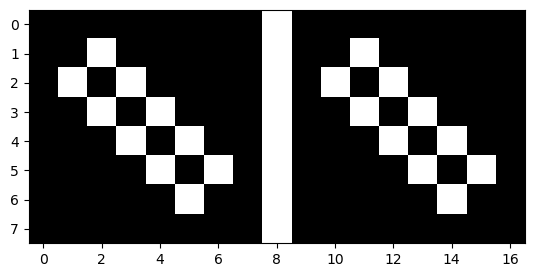

In [3]:
from mlrcv.hog_descriptor import compute_magnitude
from mlrcv.core import CHECK, plot_compare

mag_check = compute_magnitude(CHECK)

plot_compare(mag_check, 'magnitude')

If you implementation worked you should be able to see that most of the image is black except for the diagonal neighboring pixels (you can compare with the expected output in the right image). And you can check below the actual gradients for the example image that we used before.

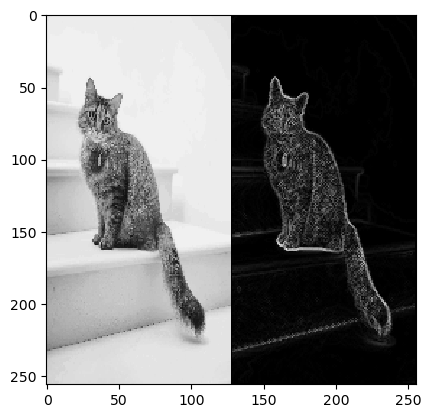

In [4]:
magnitude = compute_magnitude(img)
img_mag = np.concatenate((img, magnitude), axis=1)
plt.imshow(img_mag, cmap='gray')

**6.2 Angle image \[5\]**

---

In this task you will need to compute the angles for each pixel using again the gradients computed above. Given the gradients $Gx_{ij}$ and $Gy_{ij}$ you whould compute the angle $\theta_{ij} = tan^{-1}(\frac{Gy_{ij}}{Gx_{ij}})$. Therefore, the *compute_angle* function will similar to the *compute_magnitude* function, by first computing the gradients and then using it to compute the angle. You should implement the *compute_angle* function in `mlrcv/hog_descriptor.py`.

[[  0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 135.   0.   0.   0.   0.   0.]
 [  0.  45.   0. 135.   0.   0.   0.   0.]
 [  0.   0.  45.   0. 135.   0.   0.   0.]
 [  0.   0.   0.  45.   0. 135.   0.   0.]
 [  0.   0.   0.   0.  45.   0. 135.   0.]
 [  0.   0.   0.   0.   0.  45.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.]]


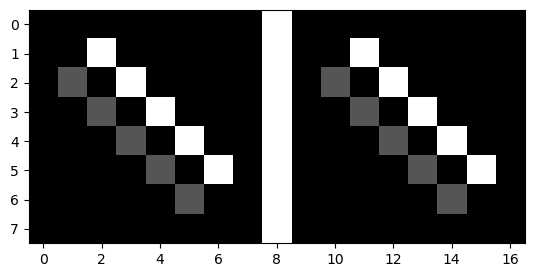

In [5]:
from mlrcv.hog_descriptor import compute_angle
from mlrcv.core import CHECK

ang_check = compute_angle(CHECK)
print(ang_check)
plot_compare(ang_check, 'angle')

If you implementation worked you should be able again to see that most of the image is black except for the diagonal neighboring pixels, where the neighbor pixels above the diagonal are white and the ones below are gray (you can compare with the expected output in the right image). And you can check below the actual angles for the example image that we used before.

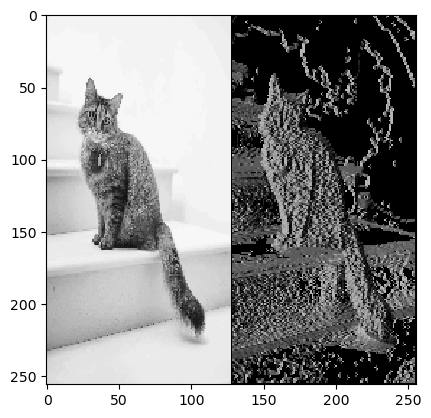

In [6]:
angle = compute_angle(img)
img_ang = np.concatenate((img, angle), axis=1)
plt.imshow(img_ang, cmap='gray')

**6.3 Compute histograms \[8\]**

---

After computing the magnitudes and angles from the images, the next task is to compute the histograms from the images to generate the hog descriptor. First, we split the angle and magnitude images into cells of $8x8$ pixels where each cell will have the correspondent pixels.

In [7]:
from mlrcv.hog_descriptor import img_to_cell
from mlrcv.core import CHECK

mag_check = compute_magnitude(CHECK)
ang_check = compute_angle(CHECK)
#print(mag_check.shape)

mag_cells = img_to_cell(mag_check)
ang_cells = img_to_cell(ang_check)
# print(mag_cells.shape)

The code above will split the *CHECK_CELL* matrix into a grid with $8x8$ pixels in each cell of the grid. For each cell you should compute an histogram using the angle and the magnitude information.

- For each cell $C_{kl}$:
    - Create an histogram $H_{kl}$ with $9$ bins dividing the angles between $0^\circ$ and $180^\circ$ (an interval of $20^\circ$ between each bin)
    - For each pixel $P_{ij}$ in the cell $C_{kl}$:
        - Check the pixel angle $\theta_{ij}$ and calculate correspondent histogram bin $b_\theta$
        - Sum the pixel magnitude $M_{ij}$ to the bin $b_\theta$ in the histogram

You should implement the histogram calculation as described above in the *create_cell_histograms* function in `mlrcv/hog_descriptor.py` (*build_hog_image* is already implemented).

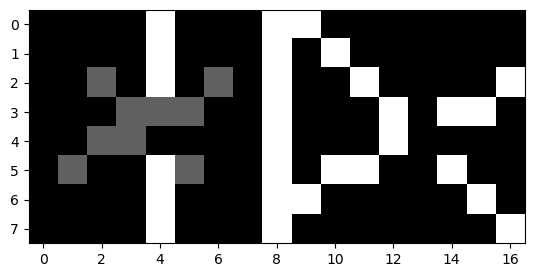

In [8]:
from mlrcv.hog_descriptor import create_cell_histograms, build_hog_image

hist_cells = create_cell_histograms(mag_cells, ang_cells)

hog_img = np.zeros((CHECK.shape[0], CHECK.shape[0]))
hog_img = build_hog_image(hog_img, hist_cells)


plot_compare(hog_img, 'hog')

If you have implemented it right you should be able to run the *build_hog_img* function which would generate *Xs* in the diagonals (you can compare with the expected output in the right image). Next, you can also check the hog descriptor over the example image and see the output result.

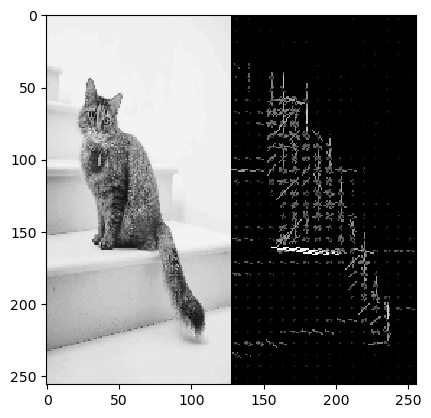

In [9]:
mag_cells = img_to_cell(magnitude)
ang_cells = img_to_cell(angle)

hist_cells = create_cell_histograms(mag_cells, ang_cells)
hog_img = np.zeros((img.shape[0], img.shape[1]))
hog_img = build_hog_image(hog_img, hist_cells)

img_hog = np.concatenate((img, hog_img), axis=1)
plt.imshow(img_hog, cmap='gray')

**Training a classifier \[2\]**

---

Now that you are to compute the descriptor for the images, the last task is to add this to a training pipeline and train a classifier to receive the descriptor and classify if the input is or not a person. You should implement the *dataloader* function in `mlrcv/hog_descriptor.py` to:

- Load the image
- Compute the magnitudes and angles
- Divide the image into the $8x8$ cells
- Compute the histograms
- Generate the hog features

This function should summarize all the steps that you have implemented so far to generate the hog image, but doing it for all the images in the train and validation sets.

In [10]:
print(magnitude.shape)
print(angle.shape)

(256, 128)
(256, 128)


In [11]:
from mlrcv.hog_descriptor import dataloader

train_feats = dataloader(train_data)
val_feats = dataloader(val_data)

classifier = train_classifier(train_feats, train_labels)
eval_classifier(classifier, val_feats, val_labels)



accuracy: 0.7777777777777778


If you have implemented right you should get an accuracy around $70\%$ which is a good result given the small dataset that we are working with. Besides, in `data/hog` you should be able to see the hog descriptor images for each one of the images on both training and validation set.